<a href="https://colab.research.google.com/github/senabyengec/Classification-of-Colorectal-Polyps-on-Histopathological-Images/blob/main/improved_classification_of_colorectal_polyps_on_histopathological_images_with_ensemble_learning_and_stain_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper: Improved Classification of Colorectal Polyps on Histopathological Images with Ensemble Learning and Stain Normalization 
Doi:(under revision)  
(Last edited: 05/02/2023)

This notebook implements the article titled "Improved Classification of Colorectal Polyps on Histopathological Images with Ensemble Learning and Stain Normalization"

Here an ensemble model is built to perform polyp classification on colon histopathology image. Ensemble model is composed of two base models which are variants of ConvNeXt.
The base models are: ConvNeXt-Base and ConvNeXt-Tiny

The experiments are performed on non-normalized dataset as well as Stain normalization applied datasets. The stain normalized datasets are curated by employing the StainTools library (https://staintools.readthedocs.io/en/latest/). The Stain-Net and Stain-GAN methods are implemented by using their source codes. 

Stain_Net: https://github.com/khtao/StainNet,
Stain-GAN:https://github.com/xtarx/StainGAN

##### Author of the code: Sena Yengec-Tasdemir

## Requirements


*   The dataset need to be uploaded to Google Drive folder. The following paths need to be updated accordingly.
*   Wandb is used for plots. One needs to either have a Wandb account or remove those lines of code.



In [ ]:
from google.colab import drive



In [ ]:
!pip install wandb
!wandb login
import wandb
from wandb.keras import WandbCallback

# Implementation of Ensemble of ConvNeXt Variants



<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import itertools
import os
from pathlib import Path
import matplotlib.pylab as plt
import numpy as np

import datetime
from tensorboard.plugins.hparams import api as hp
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

In [ ]:
print(tf.__version__)

## Select the TF2 SavedModel module to use


In [ ]:
model_name = "convnext_tiny" # @param ["convnext_large_21k_224","convnext_large_1k",'convnext_tiny','convnext_small', 'convnext_base_1k_384','convnext_large_384', 'convnext_base_21k_ft_224','convnext_base_21k_ft_384','convnext_base_21k_224']

model_handle_map = {
  "convnext_tiny":"https://tfhub.dev/sayakpaul/convnext_tiny_1k_224_fe/1",
  "convnext_small": "https://tfhub.dev/sayakpaul/convnext_small_1k_224_fe/1",
  "convnext_base_1k_384":"https://tfhub.dev/sayakpaul/convnext_base_1k_224_fe/1",
  "convnext_large_384":"https://tfhub.dev/sayakpaul/convnext_large_1k_224_fe/1",
  "convnext_base_21k_ft_224":"https://tfhub.dev/sayakpaul/convnext_base_21k_1k_224_fe/1",
  "convnext_base_21k_ft_384":"https://tfhub.dev/sayakpaul/convnext_base_21k_1k_224_fe/1",
  "convnext_base_21k_224":"https://tfhub.dev/sayakpaul/convnext_base_21k_224_fe/1",
  "convnext_large_1k":"https://tfhub.dev/sayakpaul/convnext_large_1k_224_fe/1",
  "convnext_large_21k_224": "https://tfhub.dev/sayakpaul/convnext_large_21k_224/1"

}

model_image_size_map = {
  "convnext":224,
  "convnext_small":224,
  "convnext_base_1k_224":224,
  "convnext_large_224":224,
  "convnext_base_21k_ft_224":224,
  "convnext_base_21k_ft_224":224,
  "convnext_base_21k_224":224,
  "convnext_large_1k":224,
  "convnext_large_21k_224":224,

}

pixels = model_image_size_map.get(model_name, 224)
model_handle = model_handle_map.get(model_name)
#model_handle = "https://tfhub.dev/sayakpaul/convnext_tiny_1k_224/1"
print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}
#ViT 224x224 and the range should be -1,1 instead of 0,1

Selected model: convnext_base_1k_384 : https://tfhub.dev/sayakpaul/convnext_base_1k_224_fe/1
Input size (224, 224)


## Choose dataset to work with

In here, we are experimenting on the same dataset with different normalization methods.

The structure of the Datasets: 

    path/to/image_dir/
    split_name/  # Ex: 'train'
    label1/  # Ex: 'adenom' or 'nonAdenom'
      xxx.png
      xxy.png
      xxz.png
    label2/
      xxx.png
      xxy.png
      xxz.png
    split_name/  # Ex: 'val'
    ...
    split_name/  # Ex: 'test'
    ...

In [ ]:
dataset_name = "vanilla" # @param ["public_multi",'clahe_reinhard','clahe','stain-net','public', 'vanilla', 'stain-gan', 'reinhard', 'macenko', 'vahande']


dateset_handle_map = {
  "stain-net": "/content/drive/MyDrive/PHD/labeled_stainet_normalized_train_test_val/",
  "public" : "/content/drive/MyDrive/PHD/patho_public/adenom_no_adenom_balanced/",
  "stain-gan": "/content/drive/MyDrive/PHD/labeled_staingan_normalized_train_test_val/",
  "reinhard": "/content/drive/MyDrive/PHD/labeled_reinhard_normalized_train_test_val/",
  "macenko": "/content/drive/MyDrive/PHD/labeled_macenko_normalized_train_test_val/",
  "vahande": "/content/drive/MyDrive/PHD/labeled_vahande_normalized_train_test_val/",
  "vanilla" : "/content/drive/MyDrive/PHD/histo_images_labeled_train_val/",
  "clahe": "/content/drive/MyDrive/PHD/labeled_clahe_normalized_train_test_val/",
  "clahe_reinhard":"/content/drive/MyDrive/PHD/labeled_clahe_reinhard_normalized_train_test_val",
}
dataset_handle = dateset_handle_map.get(dataset_name)

In [ ]:
path_data = Path(dataset_handle)
dest = path_data
data_dir = path_data
def build_dataset(subset, data_dir):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)
train_ds_path = os.path.join(data_dir, "train")
train_ds = build_dataset("training", train_ds_path)
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()
#For vit rescale between -1,1 for cnn 0,1, ViT: scale=1./127.5, offset=-1
normalization_layer = tf.keras.layers.Rescaling(scale=1./255) #[0,1] normalization
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))

train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))
val_ds_path= os.path.join(data_dir, 'val')
val_ds_1 = build_dataset("validation",val_ds_path)
valid_size = val_ds_1.cardinality().numpy()
val_ds_1 = val_ds_1.unbatch().batch(BATCH_SIZE)
val_ds = val_ds_1.map(lambda images, labels:
                    (normalization_layer(images), labels))

test_ds_path= os.path.join(data_dir, 'test')
test_ds_1 = build_dataset("test",val_ds_path)
test_size = test_ds_1.cardinality().numpy()
test_ds_1 = test_ds_1.unbatch().batch(BATCH_SIZE)
test_ds = test_ds_1.map(lambda images, labels:
                    (normalization_layer(images), labels))

     

In [ ]:
import matplotlib.pylab as plt
import numpy as np
x, y = next(iter(val_ds))
img = x[2, :, :, :]

plt.imshow(img)
plt.show()


## Defining the model

Define two base models to ensemble


In [ ]:
model_handle2="https://tfhub.dev/sayakpaul/convnext_tiny_1k_224_fe/1" 
model_handle3="https://tfhub.dev/sayakpaul/convnext_base_1k_224_fe/1" 

In [ ]:
do_fine_tuning = True #@param {type:"boolean"}

In [ ]:
wandb.config = {
  "learning_rate": 0.001,
  "dataset" : dataset_name,
  "model_architecture" : model_name,
  "fine_tune" : do_fine_tuning,
  "epochs": 50,
  "batch_size": BATCH_SIZE
}
wandb.init(config=wandb.config) 


## Build base models

In [ ]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.0),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False,
  name='SGD'), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])
model2 = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle2, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.0),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model2.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False,
  name='SGD'), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])



Building model with https://tfhub.dev/sayakpaul/convnext_base_1k_224_fe/1


"\nmodel3 = tf.keras.Sequential([\n    # Explicitly define the input shape so the model can be properly\n    # loaded by the TFLiteConverter\n    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),\n    hub.KerasLayer(model_handle3, trainable=do_fine_tuning),\n    tf.keras.layers.Dropout(rate=0.0),\n    tf.keras.layers.Dense(len(class_names),\n                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))\n])\n\nmodel3.compile(\n  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False,\n  name='SGD'), \n  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),\n  metrics=['accuracy'])\n"

In [ ]:
models = [model, model2] #ConvNext small and tiny
model_input = tf.keras.Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.build((None,)+IMAGE_SIZE+(3,))
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 2)            87568514    ['input_8[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 2)            27821666    ['input_8[0][0]']                
                                                                                                  
 average (Average)              (None, 2)            0           ['sequential_1[0][0]',       

## See the layers of the models

In [ ]:
s1 = ensemble_model.get_layer("sequential_1")
s1.summary()
s2 = ensemble_model.get_layer("sequential_2")
s2.summary()

layers = ensemble_model.weights
[ layers[i].name for i in range( len(layers) ) ]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_9 (KerasLayer)  (None, 1024)              87566464  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 87,568,514
Trainable params: 87,568,514
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_10 (KerasLayer)  (None, 768)              27820128  
                                                                 
 dropout_1 (Dropout)

['conv2d/kernel:0',
 'conv2d/bias:0',
 'layer_normalization/gamma:0',
 'layer_normalization/beta:0',
 'convnext_block_0_0/conv2d_4/kernel:0',
 'convnext_block_0_0/conv2d_4/bias:0',
 'convnext_block_0_0/layer_normalization_4/gamma:0',
 'convnext_block_0_0/layer_normalization_4/beta:0',
 'convnext_block_0_0/dense/kernel:0',
 'convnext_block_0_0/dense/bias:0',
 'convnext_block_0_0/dense_1/kernel:0',
 'convnext_block_0_0/dense_1/bias:0',
 'Variable:0',
 'convnext_block_0_1/conv2d_5/kernel:0',
 'convnext_block_0_1/conv2d_5/bias:0',
 'convnext_block_0_1/layer_normalization_5/gamma:0',
 'convnext_block_0_1/layer_normalization_5/beta:0',
 'convnext_block_0_1/dense_2/kernel:0',
 'convnext_block_0_1/dense_2/bias:0',
 'convnext_block_0_1/dense_3/kernel:0',
 'convnext_block_0_1/dense_3/bias:0',
 'Variable:0',
 'convnext_block_0_2/conv2d_6/kernel:0',
 'convnext_block_0_2/conv2d_6/bias:0',
 'convnext_block_0_2/layer_normalization_6/gamma:0',
 'convnext_block_0_2/layer_normalization_6/beta:0',
 'conv

## Training the model

In [ ]:
ensemble_model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False,
  name='SGD'), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE

hist = ensemble_model.fit(
    train_ds,
    epochs=50, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps)

28/28 [==============================] - 166s 4s/step - loss: 0.6755 - accuracy: 0.5737 - val_loss: 0.6891 - val_accuracy: 0.5673


In [ ]:
ev = ensemble_model.evaluate(test_ds)

13/13 [==============================] - 3s 194ms/step - loss: 0.3462 - accuracy: 0.9375


### Run this only for Convnext and ViT since it cannot use the WandB callbacks during fit

In [ ]:
num_steps = hist.params['epochs']
xs = [ i for i in range(num_steps) ]
#wandb.log({'loss': 0.2}, step=step)

#wandb.log({"loss1": hist.history['loss']},  step=num_steps)
for i in xs:
  log_dict = {
      "loss": hist.history['loss'][i],
      "epoch": i,
  }
  wandb.log(log_dict)

for i in xs:
  log_dict = {
      "val_loss": hist.history['val_loss'][i],
      "epoch": i,
  }
  wandb.log(log_dict)


for i in xs:
  log_dict = {
      "accuracy": hist.history['accuracy'][i],
      "epoch": i,
  }
  wandb.log(log_dict)

for i in xs:
  log_dict = {
      "val_accuracy": hist.history['val_accuracy'][i],
      "epoch": i,
  }
  wandb.log(log_dict)

"""           "epochs": xs,
           "accuracy": hist.history['accuracy'],
           "val_loss": hist.history['val_loss'],
           "val_accuracy": hist.history['val_accuracy']})"""

'           "epochs": xs,\n           "accuracy": hist.history[\'accuracy\'],\n           "val_loss": hist.history[\'val_loss\'],\n           "val_accuracy": hist.history[\'val_accuracy\']})'

Try out the model on an image from the validation data:

### Continue as usual 

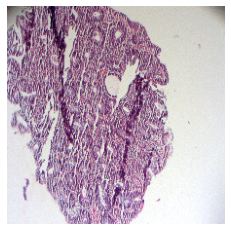

True label: adenom
Predicted label: adenom


In [ ]:
x, y = next(iter(test_ds))
image = x[2, :, :, :]
true_index = np.argmax(y[5])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

Finally, the trained model can be saved for deployment to TF Serving or TFLite (on mobile) as follows.

In [ ]:
ev = ensemble_model.evaluate(val_ds)

13/13 [==============================] - 3s 208ms/step - loss: 0.4382 - accuracy: 0.8510


In [ ]:
!pip install scikit-learn==0.23.2
!pip install keract


     |████████████████████████████████| 6.8 MB 15.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


## Confusion Martix


---



In [ ]:
##The confusion matrix

flat_class_names = [k for k in class_names]
test_ds, test_labels = next(iter(test_ds))
test_ds, test_labels = zip(*((x,y) for x,y in val_ds))
test_ds, test_labels = np.vstack(test_ds), np.vstack(test_labels)

test_predictions = ensemble_model.predict(test_ds)
ground_truth_class_ids = test_labels.argmax(axis=1)
# take the argmax for each set of prediction scores
# to return the class id of the highest confidence prediction
top_pred_ids = test_predictions.argmax(axis=1)

# Log confusion matrix
# the key "conf_mat" is the id of the plot--do not change
# this if you want subsequent runs to show up on the same plot
"""wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        preds=top_pred_ids, y_true=ground_truth_class_ids,
                        class_names=flat_class_names)})"""

'wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,\n                        preds=top_pred_ids, y_true=ground_truth_class_ids,\n                        class_names=flat_class_names)})'

In [ ]:
tf.shape(ground_truth_class_ids)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([208], dtype=int32)>

In [ ]:
# ROC 
wandb.log({"roc" : wandb.plot.roc_curve(ground_truth_class_ids, val_predictions, labels=flat_class_names, classes_to_plot=None)})


In [ ]:
wandb.log({"roc_curve" : wandb.plot.roc_curve(ground_truth_class_ids, val_predictions, labels=flat_class_names)})

In [ ]:
# ROC
wandb.log({"pr" : wandb.plot.pr_curve(ground_truth_class_ids, val_predictions,labels=flat_class_names, classes_to_plot=None)})

In [ ]:
# Learning Curve
#wandb.sklearn.plot_learning_curve(nb, X_test, y_test)

y_pred = top_pred_ids.reshape(1,-1)
y_test = ground_truth_class_ids.reshape(1,-1)
# Confusion Matrix
#wandb.sklearn.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), labels=flat_class_names)

In [ ]:
wandb.sklearn.plot_confusion_matrix(top_pred_ids, ground_truth_class_ids, labels=flat_class_names)

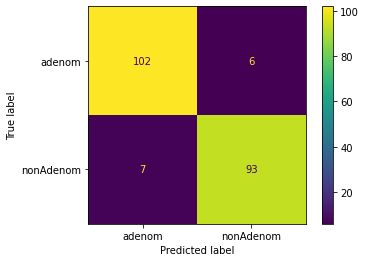

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(top_pred_ids, ground_truth_class_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=flat_class_names)
disp.plot()
plt.show()
#wandb.log({'heatmap_with_text': wandb.plots.HeatMap(flat_class_names, flat_class_names, cm, show_text=False)})